In [ ]:
%pip install mosaicml


In [1]:
%pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import pandas as pd
import numpy as np

import torch.optim as optim
from composer import Trainer
import composer
from composer.algorithms import BlurPool
from composer.loggers import InMemoryLogger

from composer.models import ComposerModel
import time


from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils

import itertools

import cv2
from PIL import Image


In [5]:
from pathlib  import Path
import pathlib
dataset_path='./data/ham10000'
meta_df=pd.read_csv(dataset_path+'/HAM10000_metadata')

In [6]:
meta_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [7]:
data = pd.read_csv(dataset_path+"/hmnist_28_28_RGB.csv")

In [8]:
data.columns

Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009',
       ...
       'pixel2343', 'pixel2344', 'pixel2345', 'pixel2346', 'pixel2347',
       'pixel2348', 'pixel2349', 'pixel2350', 'pixel2351', 'label'],
      dtype='object', length=2353)

In [9]:
yData = data['label']
XData = data.drop(columns = ['label'])

In [10]:
distribution = meta_df['dx'].value_counts()
distribution

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [11]:
dist = data['label'].value_counts()
dist

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

<Axes: >

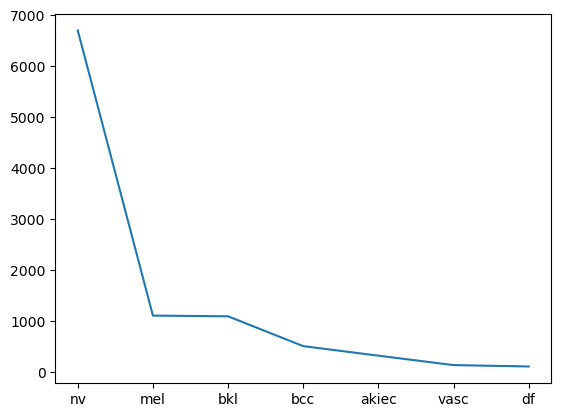

In [12]:
distribution.plot()

In [13]:
from imblearn.over_sampling import RandomOverSampler

In [14]:
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)

In [15]:
XData.shape, yData.shape

((46935, 2352), (46935,))

In [16]:
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)


In [19]:
Xtrain.shape, Xtest.shape


((37548, 28, 28, 3), (9387, 28, 28, 3))

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf

img_width, img_height = 28,28


In [21]:
input_shape = (img_width, img_height, 3)

In [22]:
model = Sequential()
model.add(Conv2D(32, (2, 2), padding='same', input_shape=input_shape))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 1)))


model.add(Conv2D(32, (2, 2), padding='same'))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 1)))


model.add(Conv2D(64, (2, 2), padding='same'))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 1)))


model.add(Flatten())
model.add(Dense(64))
model.add(Activation('swish'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer='nadam',
metrics=['accuracy'])

In [24]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [25]:
history = model.fit(Xtrain,
                    Ytrain,
                    epochs = 100,
                    validation_data = (Xtest, Ytest),
                    callbacks=[callback, early_stopping])

Epoch 1/100
1174/1174 [==============================] - ETA: 0s - loss: 1.3593 - accuracy: 0.4674
Epoch 1: saving model to best_model.h5
1174/1174 [==============================] - 10s 4ms/step - loss: 1.3593 - accuracy: 0.4674 - val_loss: 1.0460 - val_accuracy: 0.5980
Epoch 2/100
1174/1174 [==============================] - ETA: 0s - loss: 1.0279 - accuracy: 0.6096
Epoch 2: saving model to best_model.h5
1174/1174 [==============================] - 5s 4ms/step - loss: 1.0279 - accuracy: 0.6096 - val_loss: 0.8551 - val_accuracy: 0.6808
Epoch 3/100
1170/1174 [============================>.] - ETA: 0s - loss: 0.8402 - accuracy: 0.6859
Epoch 3: saving model to best_model.h5
1174/1174 [==============================] - 5s 4ms/step - loss: 0.8401 - accuracy: 0.6859 - val_loss: 0.7132 - val_accuracy: 0.7271
Epoch 4/100
1165/1174 [============================>.] - ETA: 0s - loss: 0.7017 - accuracy: 0.7395
Epoch 4: saving model to best_model.h5
1174/1174 [==============================] - 5s 

In [28]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays or pandas DataFrames to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest, dtype=torch.float32)

# If Ytrain or Ytest are pandas Series, convert them to numpy arrays first
Ytrain_array = Ytrain.values if isinstance(Ytrain, pd.Series) else Ytrain
Ytest_array = Ytest.values if isinstance(Ytest, pd.Series) else Ytest

# Convert numpy arrays to PyTorch tensors
Ytrain_tensor = torch.tensor(Ytrain_array, dtype=torch.long)
Ytest_tensor = torch.tensor(Ytest_array, dtype=torch.long)

# Create TensorDatasets
train_dataset_pytorch = TensorDataset(Xtrain_tensor, Ytrain_tensor)
test_dataset_pytorch = TensorDataset(Xtest_tensor, Ytest_tensor)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset_pytorch, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_pytorch, batch_size=BATCH_SIZE, shuffle=False)


In [29]:
def requirementsForModelTraining(model):
    blurpool = BlurPool(
    replace_convs=True, # Blur before convs
    replace_maxpools=True, # Blur before max-pools
    blur_first=True # Blur before conv/max-pool)
    )
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    algorithms=[blurpool]
    return algorithms, optimizer

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomModelComposer(ComposerModel):
    def __init__(self):
        super(CustomModelComposer, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2, padding=1)
        
        # Dense layers
        self.fc1 = nn.Linear(64*4*4, 64)  # Adjusted size after three max pooling operations
        self.fc2 = nn.Linear(64, 7)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        if isinstance(x, tuple):
            x = x[0]
        
        # Permute the dimensions to match PyTorch's expectations
        x = x.permute(0, 3, 1, 2)

        # First conv block
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Second conv block
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Third conv block
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        # Flatten and pass through FC layers
        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def get_metrics(self, is_train: bool):
        # You can return any metrics you want to monitor. 
        # If you don't have specific metrics, return an empty dictionary.
        return {}
    
    def loss(self, outputs, targets):
        if isinstance(targets, tuple):
            targets = targets[0]
        if len(targets.shape) == 4:  # [N, H, W, C]
            targets = targets.argmax(dim=-1)  # Convert to [N, H, W] with class indices
        targets = targets.view(targets.size(0), -1).argmax(dim=-1)  # Convert to [N] with class indices for entire image

        # Add these lines for debugging
        unique, counts = torch.unique(targets, return_counts=True)
        print("Unique values in targets:", unique)
        print("Counts of unique values:", counts)

        return self.criterion(outputs, targets)


# Instantiate the model
custom_model_composer = CustomModelComposer()
custom_model_composer


CustomModelComposer(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (criterion): CrossEntropyLoss()
)

In [32]:
algorithms, optimizer,  = requirementsForModelTraining(custom_model_composer)


logger = InMemoryLogger()
trainer = Trainer(
    model=custom_model_composer,
    optimizers=optimizer,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    max_duration='10ep',
    algorithms=algorithms,
    loggers=logger
)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/composer/algorithms/blurpool/blurpool.py:160: NoEffectWarning: Applying BlurPool did not change any layers. No strided Conv2d or Pool2d layers were found.
  warnings.warn(


In [33]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 0
blurpool/num_blurpool_layers: 0
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 3514876640

******************************


train          Epoch   0:    0%|| 0/1174 [00:00<?, ?ba/s]         

../aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [10,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [12,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [17,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:240: nll_lo

Unique values in targets: tensor([  0,   2,   8,  12,  25,  32, 181, 236, 240, 267, 416],
       device='cuda:0')
Counts of unique values: tensor([21,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1], device='cuda:0')


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
